<a href="https://colab.research.google.com/github/FilipeChagasDev/facial-recognition/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Neural Network (SNN) training with ResNet50 encoder

This notebook trains the SNN with ResNet50 encoder for facial recognition applications.

## What is a Siamese Neural Network

Siamese neural network (SNN) is an architecture proposed by Bromley et al in 1994. The initial objective of this architecture was to create signature recognizers, but the possibilities of this architecture are wide. In general, it is an option to solve pattern recognition problems where there is no closed and pre-defined set of classes.

The structure of an SNN can be defined as follows.

$$y = d(f(a), f(b))$$

Where:
* $a$ and $b$ are input tensors. RGB images are typically third-order tensors.
* $f$ in the encoder function. The purpose of this function is to transform the input tensors into feature vectors. This function is non-linear.
* $d$ is the distance function. The purpose of this function is to calculate the distance between the feature vectors. Herein, euclidean distance is used as $d$. 
* $y$ is the SNN output.

The SNN is trained with pairs of tensors $(a,b)$ as input, that are labeled as **1** (genuine) or **0** (impostor). The pair $(a,b)$ is genuine only if $a$ and $b$ belong to the same class. In the training process, $d(f(a), f(b))$ is conditioned to give low distances to genuine pairs and high distances to impostor pairs.

## What is a perfect SNN

A trained SNN can be considered perfect if satisfy the following condition.

* $d(f(a_1), f(b_1)) < d(f(a_2), f(d_2))$ for any genuine pair $(a_1, b_1)$ and any impostor pair $(a_2, b_2)$.

Hardly a training process results in a perfect SNN. In real situations, we just want $d(f(a_1), f(b_1)) < d(f(a_2), f(d_2))$ for most genuine pairs $(a_1, b_1)$ and for most imposter pairs $(a_2, b_2)$.

## SNN for facial recognition

In this work, we are going to train the SNN with pairs of cropped face photos from the CelebA dataset. Pairs of photos of the same person are genuine, and pairs of photos of different people are imposters.

## Code

To run this notebook on Google Colab, you will need to upload files:

* helper.py
* pairing.py
* partitioning.py
* snn.py 

First, the necessary modules will be included.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import helper
from snn import SNNGenerator, SNN

Now, CelebA will be downloaded.

In [2]:
helper.download_celeba()

Extracting celeba...
Unzipping...done


/usr/local/lib/python3.7/dist-packages/google_drive_downloader/google_drive_downloader.py:78: UserWarning: Ignoring `unzip` since "1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


Now, **training** and **validation** partitions will be created. The **build_celeba_partitions** function generates the **celeba_partitions/partitions.json** file that separates the **validation** people from the **training** people. Validation and training are make with photos of different persons.

In [3]:
from partitioning import build_celeba_partitions
build_celeba_partitions()

Generating partitions (EVAL=1/4, TRAIN=3/4)


Now the next code cell generates the paired image metadata. It might take a while.

The *build_celeba_pairs* function generates four CSV files: *eval_genuine_pairs.csv*, *eval_impostor_pairs.csv*, *training_genuine_pairs.csv* and *training_impostor_pairs.csv*. These files have the following format:

|file_a|person_a|file_b|person_b|
|:----:|:------:|:----:|:------:|
| ...  | ...    | ...  | ...    |

* The **file_a** column has photo filenames $a$.
* The **person_a** column has person identifiers $a$. Each person is identified by an integer greater than 0.
* The **file_b** column has photo filenames $b$.
* The **person_b** column has person identifiers $b$.

In files *eval_impostor_pairs.csv* and *training_impostor_pairs.csv*, all the rows have different values for *person_a* and *person_b*. In files *eval_genuine_pairs.csv* and *training_impostor_pairs.csv*, all the rows have equal values for *person_a* and *person_b*.

In [4]:
from pairing import build_celeba_pairs
build_celeba_pairs()

EVAL
Generating genuine pairs


100%|██████████| 2544/2544 [00:32<00:00, 78.31it/s]


Generating imporstor pairs


100%|██████████| 2544/2544 [01:36<00:00, 26.43it/s]


TRAINING
Generating genuine pairs


100%|██████████| 7633/7633 [02:22<00:00, 53.57it/s]


Generating imporstor pairs


100%|██████████| 7633/7633 [05:09<00:00, 24.64it/s]


The following function loads a batch of images and formats them to the encoder.

* Width: 80px
* Height: 80px
* Format: RGB (3 channels)
* Data type: Unitary floats (between 0 and 1)

In [5]:
def load_images(paths):
    images = [helper.get_image(path, 80, 80, 'RGB').astype(np.float)/255 for path in paths]
    return np.array(images)

The next cell loads the CSVs generated by *build_celeba_pairs*.

In [6]:
training_genuine_pairs = pd.read_csv(os.path.join('celeba_pairs', 'training_genuine_pairs.csv'))
training_impostor_pairs = pd.read_csv(os.path.join('celeba_pairs', 'training_impostor_pairs.csv'))
eval_genuine_pairs = pd.read_csv(os.path.join('celeba_pairs', 'eval_genuine_pairs.csv'))
eval_impostor_pairs = pd.read_csv(os.path.join('celeba_pairs', 'eval_impostor_pairs.csv'))

CelebA is a big dataset. To reduce the amount of time needed to train the SNN, it is necessary to randomly sample data from the dataset.

In [7]:
divider = 50
training_genuine_pairs = training_genuine_pairs.sample(n=training_genuine_pairs.shape[0]//divider, random_state=1)
training_impostor_pairs = training_impostor_pairs.sample(n=training_impostor_pairs.shape[0]//divider, random_state=1)
eval_genuine_pairs = eval_genuine_pairs.sample(n=eval_genuine_pairs.shape[0]//divider, random_state=1)
eval_impostor_pairs = eval_impostor_pairs.sample(n=eval_impostor_pairs.shape[0]//divider, random_state=1)


The next cell implements the data generator needed to train the SNN. The generator is a class that loads and formats the images of each training batch.

In [8]:
class CelebAGenerator(SNNGenerator):
    def __init__(self, genuine_pairs_df: pd.DataFrame, impostor_pairs_df: pd.DataFrame, batch_size: int):
        self.__genuine_pairs_df__ = genuine_pairs_df
        self.__impostor_pairs_df__ = impostor_pairs_df
        self.__batch_size__ = batch_size
    
    def __len__(self):
        return (self.__genuine_pairs_df__.shape[0]+self.__impostor_pairs_df__.shape[0])//self.__batch_size__

    def __getitem__(self, index: int):
        def get_genuines():
            my_rows = self.__genuine_pairs_df__.sample(n=self.__batch_size__//2, replace=False)
            images_a = load_images([os.path.join('celeba', 'img_align_celeba', fn) for fn in list(my_rows['file_a'])])
            images_b = load_images([os.path.join('celeba', 'img_align_celeba', fn) for fn in list(my_rows['file_b'])])
            images_y = np.ones(shape=(self.__batch_size__//2,1))
            return images_a, images_b, images_y

        def get_impostors():
            my_rows = self.__impostor_pairs_df__.sample(n=self.__batch_size__//2, replace=False)
            images_a = load_images([os.path.join('celeba', 'img_align_celeba', fn) for fn in list(my_rows['file_a'])])
            images_b = load_images([os.path.join('celeba', 'img_align_celeba', fn) for fn in list(my_rows['file_b'])])
            images_y = np.zeros(shape=(self.__batch_size__//2,1))
            return images_a, images_b, images_y

        genuines_a, genuines_b, genuines_y = get_genuines()
        impostors_a, impostors_b, impostors_y = get_impostors()
        a = np.append(genuines_a, impostors_a, axis=0)
        b = np.append(genuines_b, impostors_b, axis=0)
        y = np.append(genuines_y, impostors_y, axis=0)
        return ([a, b], y)

We use ResNet50 as an encoder, just adding an extra linear layer. Feature vectors have 100 entries (features).
The following cell defines the function that creates the encoder.

In [9]:
def build_resnet50_encoder(n_features=100):
    base_model = ResNet50(weights=None, include_top=False, input_shape=(80,80,3))
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.7)(x)
    x = layers.Dense(n_features, activation='linear')(x)
    model = keras.Model(inputs = base_model.input, outputs = x)
    return model

The next cell creates the SNN.

In [10]:
my_snn = SNN((80,80,3),build_resnet50_encoder())

The next cell creates the generators and trains the SNN.

The loss function used is the **Contrastive Loss**, proposed by Lian et al in 2018.

$$L(y,d)= yd^2 + (1-y)\max\{m-d,0\}^2$$

Where:
* $y$ is the label (**1** for genuine pairs and **0** for impostor pairs).
* $d$ is the euclidean distance between $a$ and $b$.

In [11]:
training_generator = CelebAGenerator(training_genuine_pairs, training_impostor_pairs, 50)
eval_generator = CelebAGenerator(eval_genuine_pairs, eval_impostor_pairs, 50)
my_snn.fit(training_generator, eval_generator, epochs=100)

EPOCH 1 OF 100


100%|██████████| 121/121 [01:35<00:00,  1.27it/s]


training_loss = 176.7977


100%|██████████| 40/40 [00:14<00:00,  2.76it/s]


validation_loss=0.2976
EPOCH 2 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 20.8482


100%|██████████| 40/40 [00:12<00:00,  3.30it/s]


validation_loss=0.2712
EPOCH 3 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 6.5777


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=0.4389
EPOCH 4 OF 100


100%|██████████| 121/121 [01:18<00:00,  1.55it/s]


training_loss = 3.0902


100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


validation_loss=0.4332
EPOCH 5 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.66it/s]


training_loss = 1.6791


100%|██████████| 40/40 [00:12<00:00,  3.30it/s]


validation_loss=0.5501
EPOCH 6 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.64it/s]


training_loss = 0.8475


100%|██████████| 40/40 [00:12<00:00,  3.30it/s]


validation_loss=0.4078
EPOCH 7 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.7328


100%|██████████| 40/40 [00:12<00:00,  3.30it/s]


validation_loss=0.5976
EPOCH 8 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.5485


100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


validation_loss=0.4615
EPOCH 9 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.4144


100%|██████████| 40/40 [00:12<00:00,  3.31it/s]


validation_loss=0.4806
EPOCH 10 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.3594


100%|██████████| 40/40 [00:11<00:00,  3.34it/s]


validation_loss=0.7706
EPOCH 11 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.3185


100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


validation_loss=0.5007
EPOCH 12 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.3254


100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


validation_loss=0.4774
EPOCH 13 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.3142


100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


validation_loss=1.3499
EPOCH 14 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.2817


100%|██████████| 40/40 [00:12<00:00,  3.33it/s]


validation_loss=0.5844
EPOCH 15 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.66it/s]


training_loss = 0.3066


100%|██████████| 40/40 [00:12<00:00,  3.19it/s]


validation_loss=0.5513
EPOCH 16 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.2856


100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


validation_loss=0.5079
EPOCH 17 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.67it/s]


training_loss = 0.2761


100%|██████████| 40/40 [00:11<00:00,  3.35it/s]


validation_loss=0.4070
EPOCH 18 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.2845


100%|██████████| 40/40 [00:12<00:00,  3.30it/s]


validation_loss=0.6476
EPOCH 19 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.2977


100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


validation_loss=3.8978
EPOCH 20 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.66it/s]


training_loss = 0.2958


100%|██████████| 40/40 [00:12<00:00,  3.30it/s]


validation_loss=0.5092
EPOCH 21 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.2879


100%|██████████| 40/40 [00:12<00:00,  3.32it/s]


validation_loss=0.5841
EPOCH 22 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.2679


100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


validation_loss=0.6749
EPOCH 23 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.2679


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


validation_loss=0.4474
EPOCH 24 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.2752


100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


validation_loss=2.4695
EPOCH 25 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.2741


100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


validation_loss=0.4626
EPOCH 26 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.3220


100%|██████████| 40/40 [00:12<00:00,  3.30it/s]


validation_loss=0.9021
EPOCH 27 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.2619


100%|██████████| 40/40 [00:12<00:00,  3.30it/s]


validation_loss=0.6267
EPOCH 28 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.2538


100%|██████████| 40/40 [00:12<00:00,  3.30it/s]


validation_loss=0.4353
EPOCH 29 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.66it/s]


training_loss = 0.2550


100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


validation_loss=0.6710
EPOCH 30 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.2379


100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


validation_loss=0.3605
EPOCH 31 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.2170


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=0.4595
EPOCH 32 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.1762


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


validation_loss=0.4206
EPOCH 33 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.1538


100%|██████████| 40/40 [00:12<00:00,  3.21it/s]


validation_loss=0.3777
EPOCH 34 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.1389


100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


validation_loss=0.3410
EPOCH 35 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.66it/s]


training_loss = 0.1849


100%|██████████| 40/40 [00:12<00:00,  3.30it/s]


validation_loss=0.8894
EPOCH 36 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.1252


100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


validation_loss=0.5511
EPOCH 37 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0944


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=0.3812
EPOCH 38 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.64it/s]


training_loss = 0.0888


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


validation_loss=0.4088
EPOCH 39 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0930


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


validation_loss=0.4480
EPOCH 40 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0805


100%|██████████| 40/40 [00:12<00:00,  3.20it/s]


validation_loss=0.5260
EPOCH 41 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0696


100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


validation_loss=0.4429
EPOCH 42 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0643


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


validation_loss=0.4081
EPOCH 43 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0628


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


validation_loss=0.4195
EPOCH 44 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.1372


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.3766
EPOCH 45 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.1252


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=0.3412
EPOCH 46 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.1028


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


validation_loss=0.3030
EPOCH 47 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0881


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=0.2839
EPOCH 48 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0739


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.2915
EPOCH 49 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0639


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


validation_loss=0.3817
EPOCH 50 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0615


100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


validation_loss=0.3798
EPOCH 51 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0774


100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


validation_loss=0.3228
EPOCH 52 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.64it/s]


training_loss = 0.0913


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=1.7644
EPOCH 53 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.66it/s]


training_loss = 0.0641


100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


validation_loss=0.2793
EPOCH 54 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0579


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.3844
EPOCH 55 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.66it/s]


training_loss = 0.0516


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


validation_loss=5.5886
EPOCH 56 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0592


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=0.2968
EPOCH 57 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0693


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


validation_loss=0.2795
EPOCH 58 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0577


100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


validation_loss=0.3700
EPOCH 59 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.66it/s]


training_loss = 0.0537


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.2662
EPOCH 60 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0553


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


validation_loss=0.2643
EPOCH 61 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0684


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.7063
EPOCH 62 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0612


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=0.2975
EPOCH 63 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.0443


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


validation_loss=0.8028
EPOCH 64 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.64it/s]


training_loss = 0.0471


100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


validation_loss=0.2429
EPOCH 65 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0577


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.4869
EPOCH 66 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0382


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


validation_loss=0.1693
EPOCH 67 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.64it/s]


training_loss = 0.0255


100%|██████████| 40/40 [00:12<00:00,  3.21it/s]


validation_loss=0.1376
EPOCH 68 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.64it/s]


training_loss = 0.0188


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.1748
EPOCH 69 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0166


100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


validation_loss=0.1825
EPOCH 70 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0147


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.1646
EPOCH 71 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0216


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.5134
EPOCH 72 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0211


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=0.1522
EPOCH 73 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0170


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.1500
EPOCH 74 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.0178


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=0.2202
EPOCH 75 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.66it/s]


training_loss = 0.0237


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=0.1807
EPOCH 76 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0247


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


validation_loss=0.2363
EPOCH 77 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0242


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.2050
EPOCH 78 OF 100


100%|██████████| 121/121 [01:14<00:00,  1.63it/s]


training_loss = 0.0397


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.2409
EPOCH 79 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.64it/s]


training_loss = 0.0282


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.2915
EPOCH 80 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0245


100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


validation_loss=0.2348
EPOCH 81 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.64it/s]


training_loss = 0.0265


100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


validation_loss=0.2179
EPOCH 82 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0471


100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


validation_loss=0.5164
EPOCH 83 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0361


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


validation_loss=0.1414
EPOCH 84 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.66it/s]


training_loss = 0.0146


100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


validation_loss=0.1351
EPOCH 85 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0122


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


validation_loss=0.1323
EPOCH 86 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0093


100%|██████████| 40/40 [00:12<00:00,  3.20it/s]


validation_loss=0.1389
EPOCH 87 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0079


100%|██████████| 40/40 [00:12<00:00,  3.14it/s]


validation_loss=0.1373
EPOCH 88 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0087


100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


validation_loss=0.1470
EPOCH 89 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.66it/s]


training_loss = 0.0107


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


validation_loss=0.1419
EPOCH 90 OF 100


100%|██████████| 121/121 [01:12<00:00,  1.66it/s]


training_loss = 0.0088


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


validation_loss=0.1353
EPOCH 91 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0081


100%|██████████| 40/40 [00:16<00:00,  2.48it/s]


validation_loss=0.1470
EPOCH 92 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0112


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


validation_loss=0.1637
EPOCH 93 OF 100


100%|██████████| 121/121 [01:23<00:00,  1.44it/s]


training_loss = 0.0079


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=0.1438
EPOCH 94 OF 100


100%|██████████| 121/121 [01:15<00:00,  1.61it/s]


training_loss = 0.0097


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


validation_loss=0.1471
EPOCH 95 OF 100


100%|██████████| 121/121 [01:30<00:00,  1.33it/s]


training_loss = 0.0123


100%|██████████| 40/40 [00:18<00:00,  2.14it/s]


validation_loss=0.1312
EPOCH 96 OF 100


100%|██████████| 121/121 [01:36<00:00,  1.25it/s]


training_loss = 0.0101


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=1.8887
EPOCH 97 OF 100


100%|██████████| 121/121 [01:15<00:00,  1.61it/s]


training_loss = 0.0094


100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


validation_loss=0.1747
EPOCH 98 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.64it/s]


training_loss = 0.0130


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


validation_loss=0.1543
EPOCH 99 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.64it/s]


training_loss = 0.0140


100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


validation_loss=0.1703
EPOCH 100 OF 100


100%|██████████| 121/121 [01:13<00:00,  1.65it/s]


training_loss = 0.0228


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]

validation_loss=0.1833


The next cell plots the evolution of the training loss and the validation loss over the course of training.

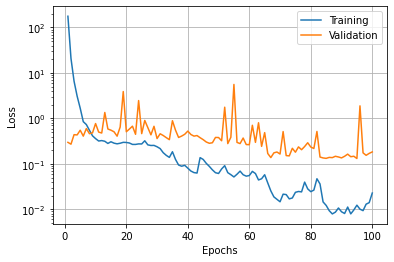

In [14]:
plt.plot([i+1 for i in range(len(my_snn.training_loss_history))], my_snn.training_loss_history, label='Training')
plt.plot([i+1 for i in range(len(my_snn.validation_loss_history))], my_snn.validation_loss_history, label='Validation')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.legend()
plt.grid()
plt.show()

The next cell saves encoder's weights to a file. We will use this encoder later as part of a prediction framework.

In [13]:
my_snn.save_encoder('resnet50_encoder_weights.h5')

**If you're on Google Colab, don't forget to download the file *resnet50_encoder_weights.h5* as it will be needed to run the other notebooks.**